<a href="https://colab.research.google.com/github/Sriva29/bert-learning-analytics/blob/Tarun_dev/eda-and-preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the Sight Dataset and the Coursera Review Dataset and Preprocessing/Cleaning them

In [2]:
pip install langdetect unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 15.4 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=6d46fe294c626f47e76ff5264db21af80b5b247ea42613637f016532696fb162
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [3]:
import pandas as pd

# sight_df = pd.read_csv(
#     "data/sight_dataset.csv",
#     delimiter=",",               # Specify delimiter
#     quotechar='"',               # Handle embedded quotes
#     escapechar="\\",             # Escape special characters
#     on_bad_lines="skip",         # Skip problematic lines
#     engine="python"              # Use the Python parser for flexibility
# )

# Upon analysis, we discovered that this dataset can be used to test since it is unlabelled.
#sight_df.head()

coursera_df = pd.read_csv("https://raw.githubusercontent.com/Sriva29/bert-learning-analytics/refs/heads/main/data/reviews_by_course.csv")
coursera_df.head()

,CourseId,Review,Label
0,2-speed-it,BOring,1
1,2-speed-it,Bravo !,5
2,2-speed-it,Very goo,5
3,2-speed-it,"Great course - I recommend it for all, especia...",5
4,2-speed-it,One of the most useful course on IT Management!,5


In [4]:
#Inspecting the data types and checking if there are any missing values
print(coursera_df.info())
print(coursera_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140320 entries, 0 to 140319
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   CourseId  140320 non-null  object
 1   Review    140317 non-null  object
 2   Label     140320 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.2+ MB
None
CourseId    0
Review      3
Label       0
dtype: int64


In [5]:
# Since only 3 missing values, dropping them
coursera_df = coursera_df.dropna(subset=["Review"])
print(coursera_df.isnull().sum())

CourseId    0
Review      0
Label       0
dtype: int64


In [6]:
#Checking label distribution
print(coursera_df["Label"].value_counts())

Label
5    106514
4     22460
3      5923
1      2866
2      2554
Name: count, dtype: int64


In [7]:
'''At this point, given that the dataset is skewed with a lot more rows labelled 5 than not, given the choice of undersampling label 5, oversampling the lower labels 1-4,
and using class weights, we decided to go with class weights to avoid artificially adding data (fake reviews) to the dataset.
'''

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

#Defining the classes and their freq

classes = sorted(coursera_df["Label"].unique())
print(classes)
classes = np.array(classes)
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = classes,
    y=coursera_df["Label"]
)

#Converting to dictionary for easy ref
class_weights_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
print(class_weights_dict)


[1, 2, 3, 4, 5]
{1: 9.791835310537333, 2: 10.988018794048552, 3: 4.738038156339693, 4: 1.2494835262689226, 5: 0.26347146853934694}


Upon visual inspection of the dataset, we noticed some issues:

1. Non-English Reviews: Some of the reviews are in spanish. In BERT is pre-trained on English text, this will cause problems and affect fine-tuning quality.
2. Gibberish and Encoding issues: We found that some of the reviews had plain gibberish text. eg: Ð”Ð¾ÑÑ‚ÑƒÐ¿Ð½Ð¾ Ð¸ Ð¸Ð½Ñ‚ÐµÑ€ÐµÑÐ½Ð¾. We will either correct the encoding errors or drop them.

In [8]:
# install langdetect and unidecode

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

#Detecting each review language
coursera_df["Language"] = coursera_df["Review"].apply(detect_language)

#filtering only English reviews
english_reviews_df = coursera_df[coursera_df["Language"]=="en"]

print(english_reviews_df["Language"].value_counts())
english_reviews_df.head()

Language
en    106882
Name: count, dtype: int64


,CourseId,Review,Label,Language
3,2-speed-it,"Great course - I recommend it for all, especia...",5,en
4,2-speed-it,One of the most useful course on IT Management!,5,en
5,2-speed-it,I was disappointed because the name is mislead...,3,en
6,2-speed-it,Super content. I'll definitely re-do the course,5,en
8,2-speed-it,One of the excellent courses at Coursera for i...,5,en


In [9]:
#Fixing giberrish

from unidecode import unidecode

english_reviews_df["cleaned_review"] = english_reviews_df["Review"].apply(unidecode)

print(english_reviews_df["cleaned_review"].head())
print(english_reviews_df.shape)


3    Great course - I recommend it for all, especia...
4      One of the most useful course on IT Management!
5    I was disappointed because the name is mislead...
6      Super content. I'll definitely re-do the course
8    One of the excellent courses at Coursera for i...
Name: cleaned_review, dtype: object
(106882, 5)


<ipython-input-9-1ef3e2362a9d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df["cleaned_review"] = english_reviews_df["Review"].apply(unidecode)


In [10]:
#Checking whether original df had more langs

print(coursera_df["Language"].value_counts())



Language
en         106882
es          12273
fr           3631
zh-cn        2333
pt           2225
ro           2104
ca           1982
ru           1529
af           1514
so            986
de            774
it            529
no            400
tl            339
ko            326
cy            258
sw            255
id            220
unknown       206
nl            186
vi            179
pl            173
sl            161
da            138
cs             84
et             83
sk             75
sq             71
zh-tw          51
tr             50
sv             50
fi             44
hr             36
hu             35
bg             32
lt             31
uk             16
mk             14
lv             13
he             11
ar             10
fa              4
ja              2
ur              1
el              1
Name: count, dtype: int64


In [12]:
# Saving new csv
# english_reviews_df.to_csv("data/coursera_english_reviews.csv", index=False)


Now that we only have English reviews, time to apply standard text preprocessing such as conversion to lowercase, punctuation removal, special character removal, and extra whitespace removal

In [13]:
import re

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Applying cleaning to the Review column
english_reviews_df["cleaned_review"] = english_reviews_df["Review"].apply(clean_text)

# Verifying the changes
print(english_reviews_df[["Review", "cleaned_review"]].head())

                                              Review  \
3  Great course - I recommend it for all, especia...   
4    One of the most useful course on IT Management!   
5  I was disappointed because the name is mislead...   
6    Super content. I'll definitely re-do the course   
8  One of the excellent courses at Coursera for i...   

                                      cleaned_review  
3  great course i recommend it for all especially...  
4     one of the most useful course on it management  
5  i was disappointed because the name is mislead...  
6       super content ill definitely redo the course  
8  one of the excellent courses at coursera for i...  


<ipython-input-13-cb3b9402fbce>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df["cleaned_review"] = english_reviews_df["Review"].apply(clean_text)


In [18]:
print(english_reviews_df.head)

<bound method NDFrame.head of           CourseId                                             Review  Label  \
3       2-speed-it  Great course - I recommend it for all, especia...      5   
4       2-speed-it    One of the most useful course on IT Management!      5   
5       2-speed-it  I was disappointed because the name is mislead...      3   
6       2-speed-it    Super content. I'll definitely re-do the course      5   
8       2-speed-it  One of the excellent courses at Coursera for i...      5   
...            ...                                                ...    ...   
140315        zika  Trendy topic with talks from expertises in the...      4   
140316        zika  Wonderful! Simple and clear language, good ins...      5   
140317        zika   an interesting and fun course. thanks. dr quincy      5   
140318        zika  very broad perspective, up to date information...      4   
140319        zika  An informative course on the social and financ...      4   

       La

In [19]:
!pip install cloudwatch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 7.0 MB/s eta 0:00:00


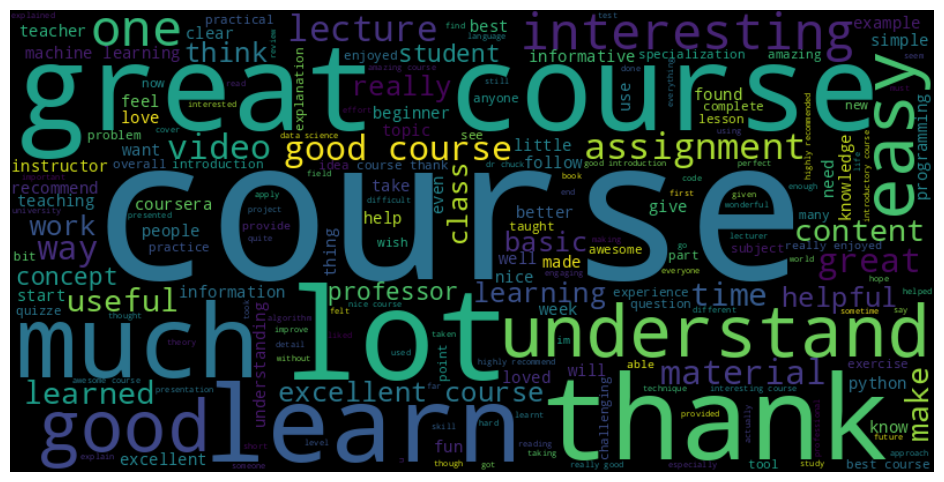

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = ' '.join(english_reviews_df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
# splitting the labels in 3 parts , so we can use sparse_categorical_crossentropy loss function while training the model.
def map_sentiment(Label):
    if Label <= 2:
        return 'Negative'
    elif Label == 3:
        return 'Neutral'
    else:
        return 'Positive'

english_reviews_df['Sentiment'] = english_reviews_df['Label'].apply(map_sentiment)
print(english_reviews_df['Sentiment'].value_counts())

Sentiment
Positive    97105
Neutral      5070
Negative     4707
Name: count, dtype: int64


<ipython-input-21-a1cc3587055e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df['Sentiment'] = english_reviews_df['Label'].apply(map_sentiment)


In [22]:
# split the dataset to train with logistic regression model.
from sklearn.model_selection import train_test_split

X = english_reviews_df['cleaned_review']
y = english_reviews_df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9250128642933995
              precision    recall  f1-score   support

    Negative       0.65      0.47      0.54       926
     Neutral       0.44      0.11      0.18      1046
    Positive       0.94      0.99      0.96     19405

    accuracy                           0.93     21377
   macro avg       0.68      0.52      0.56     21377
weighted avg       0.90      0.93      0.91     21377



In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/5
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 648s 481ms/step - accuracy: 0.9056 - loss: 0.3086 - val_accuracy: 0.9256 - val_loss: 0.2106
Epoch 2/5
1049/1337 ━━━━━━━━━━━━━━━━━━━━ 1:47 375ms/step - accuracy: 0.9293 - loss: 0.1882

In [ ]:
# Testing the accuracy ans overall score without finetuning the models.
from sklearn.metrics import confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_pred_lstm = model.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm))

In [ ]:
#  Now lets try with LSTM model by finetuning it.

In [ ]:
# splitting the labels in 2 categories to use binary_crossentropy loss function.
english_reviews_df.loc[english_reviews_df['Label'] <= 3, 'Label'] = 0
english_reviews_df.loc[english_reviews_df['Label'] > 3, 'Label'] = 1

In [ ]:


# Tokenize the text
max_words = 20000  # Vocabulary size
max_len = 100  # Max length of sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(english_reviews_df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(english_reviews_df['cleaned_review'])
X = pad_sequences(sequences, maxlen=max_len)

# Define labels
y = english_reviews_df['Label'].values

In [ ]:
# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# 4. Build the Model
model = Sequential([
    Embedding(max_words, 128, input_shape=(max_len,)),  # Updated to input_shape
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Build the model explicitly to resolve the warning
model.build(input_shape=(None, max_len))  # Batch size is None
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    verbose=1,
    class_weight=class_weights_dict  # Applying class weights here
)

In [ ]:
# 6. Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict and evaluate further
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
# now lets try to increase the weights of the minority class

In [ ]:
# Spliting the data to train it on Bert
# When using BERT, we need PyTorch datasets instead of feeding NumPy arrays directly. thats y this split.
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(english_reviews_df, test_size=0.2, stratify=english_reviews_df["Label"], random_state=37)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

Tokenizing using BERT from Hugging Face Transformers library

In [ ]:
# Analyzing dataset to determine max_length for BERT tokenization
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# review_lengths = english_reviews_df["cleaned_review"].apply(lambda x: len(tokenizer.tokenize(x)))
# print(review_lengths.describe())  # Check mean, median, and max token length


In [ ]:
print(english_reviews_df.columns)

In [ ]:
#Verifying GPU usage
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name(0))


In [ ]:
from transformers import BertTokenizer

# Load a tokenizer to test
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
print("Transformers library is functional!")


In [ ]:
# Given that token lenght rarely even touches 128, we will keep max_lenght as 128
#
import torch
def tokenize_data(data):
    return tokenizer(
        list(data["cleaned_review"]),
        padding = True,
        truncation = True,
        max_length = 128,
        return_tensors="pt"
    )

train_encodings = tokenize_data(train_data)
val_encodings = tokenize_data(val_data)

print("Tokenization has been completed!")
# print(train_encodings)
# print(val_encodings)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split  # Import train_test_split
from sklearn.metrics import classification_report

In [ ]:
english_reviews_df.loc[english_reviews_df['Label'] <= 3, 'Label'] = 0
english_reviews_df.loc[english_reviews_df['Label'] > 3, 'Label'] = 1

In [ ]:
# 4. Build the Model

max_words = 10000  # Vocabulary size
max_len = 100  # Max length of sequences
model = Sequential([
    Embedding(max_words, 128, input_shape=(max_len,)),  # Updated to input_shape
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Build the model explicitly to resolve the warning
model.build(input_shape=(None, max_len))  # Batch size is None
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    verbose=1,
    class_weight=class_weights_dict  # Applying class weights here
)